01 - Basic Forecasting Workflows

This section explains the basic forecasting workflows, and key interface points for it.

We cover the following four workflows:

- basic deployment workflow: batch fitting and forecasting
- basic evaluation workflow: evaluating a batch of forecasts against ground truth observations
- advanced deployment workflow: fitting and rolling updates/forecasts
- advanced evaluation worfklow: using rolling forecast splits and computing split-wise and aggregate errors, including common back-testing schemes

1.1 Data contanier format
All workflows make common assumptions on the input data format.

sktime uses pandas for representing time series:
 - pd.Series for univariate time series and sequences
 - pd.DataFrame for multivariate time series and sequences
The Series.index and DataFrame.index are used for representing the time series or sequence index. sktime supports pandas integer, period and timestamp indices.

Example: as the running example in this tutorial, we use a textbook data set, the Box-Jenkins airline data set, which consists of the number of monthly totals of international airline passengers, from 1949 - 1960. Values are in thousands. See "Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications", exercises sections 2 and 3.

In [2]:
import pandas as pd
import numpy as np
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

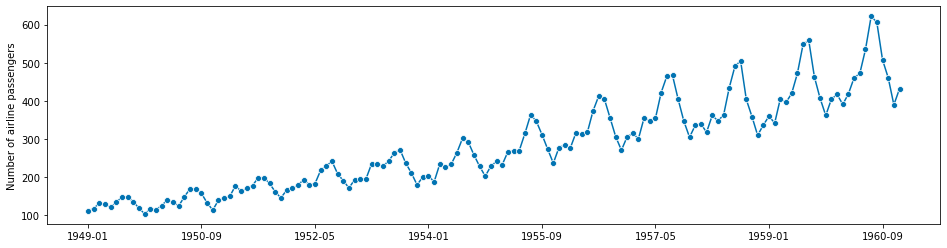

In [3]:
y = load_airline()

# plotting for visualization
plot_series(y)

In [4]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

Generally, users are expected to use the in-built loading functionality of pandas and pandas-compatible packages to load data sets for forecasting, such as read_csv or the Series or DataFrame constructors if data is available in another in-memory format, e.g., numpy.array.

sktime forecasters may accept input in pandas-adjacent formats, but will produce outputs in, and attempt to coerce inputs to, pandas formats.

NOTE: if your favourite format is not properly converted or coerced, kindly consider to contribute that functionality to sktime.

1.2 Basic deployment workflow - batch fitting and forecasting
The simplest use case workflow is batch fitting and forecasting, i.e., fitting a forecasting model to one batch of past data, then asking for forecasts at time point in the future.

The steps in this workflow are as follows:
 Step 1: Preparation of the data
 Step 2: Specification of the time points for which forecasts are requested. This uses a numpy.array or the ForecastingHorizon object.
 Step 3: Specification and instantiation of the forecaster. This follows a scikit-learn-like syntax; forecaster objects follow the familiar scikit-learn BaseEstimator interface.
 Step 4: fitting the forecaster to the data, using the forecaster's fit method
 Step 5: making a forecast, using the forecaster's predict method
The below first outlines the vanilla variant of the basic deployment workflow, step-by-step.

At the end, one-cell workflows are provided, with common deviations from the pattern (Sections 1.2.1 and following).

In [5]:
%whos

Variable                    Type        Data/Info
-------------------------------------------------
load_airline                function    <function load_airline at 0x000002BDE45E7790>
np                          module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os                          module      <module 'os' from 'C:\\Us<...>ata_process\\lib\\os.py'>
pd                          module      <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plot_series                 function    <function plot_series at 0x000002BDE45E7B80>
site                        module      <module 'site' from 'C:\\<...>a_process\\lib\\site.py'>
sys                         module      <module 'sys' (built-in)>
temporal_train_test_split   function    <function temporal_train_<...>it at 0x000002BDE38F63A0>
y                           Series      1949-01    112.0\n1949-02<...>ngth: 144, dtype: float64


In [6]:
y

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

Step 1 - preparation of the data
as discussed in Section 1.1, the data is assumed to be in pd.Series (univariate) or pd.DataFrame (multivariate) format.
Our variable y is pd.Series

In [7]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

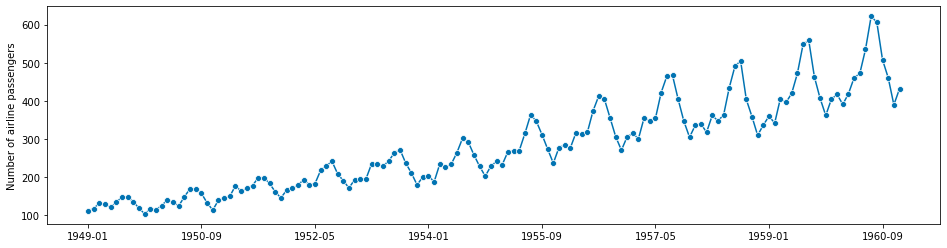

In [8]:
# in the example, we use the airline data set.
y = load_airline()
plot_series(y)

step 2 - specifying the forecasting horizon
Now we need to specify the forecasting horizon and pass that to our forecasting algorithm.

There are two main ways:
 - Using a numpy.array of integers. This assumes either integer index or periodic index (PeriodIndex) in the time series; the integer indicates the number of time points or periods ahead we want to make a forecast for. E.g., 1 means forecast the next period, 2 the second next period, and so on.
 - Using a ForecastingHorizon object. This can be used to define forecast horizons, using any supported index type as an argument. No periodic index is assumed.
Forecasting horizons can be absolute, i.e., referencing specific time points in the future, or relative, i.e., referencing time differences to the present. As a default, the present is that latest time point seen in any y passed to the forecaster.

numpy.array based forecasting horizons are always relative; ForecastingHorizon objects can be both relative and absolute. In particular, absolute forecasting horizons can only be specified using ForecastingHorizon.

using a numpy forecasting horizon

In [9]:
import numpy as np
fh = np.arange(1, 37)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

This will ask for monthly predictions for the next three years, since the original series period is 1 month. In another example, to predict only the second and fifth month ahead, one could write:

In [10]:
import numpy as np
fh = np.array([2, 5])  # 2nd and 5th step ahead

Using a ForecastingHorizon based forecasting horizon
The ForecastingHorizon object takes absolute indices as input, but considers the input absolute or relative depending on the is_relative flag.

ForecastingHorizon will automatically assume a relative horizon if temporal difference types from pandas are passed; if value types from pandas are passed, it will assume an absolute horizon.

To define an absolute ForecastingHorizon in our example:

In [11]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

ForecastingHorizon-s can be converted from relative to absolute and back via the to_relative and to_absolute methods. Both of these conversions require a compatible cutoff to be passed:

In [12]:
cutoff = pd.Period("1960-12", freq="M")
fh.to_relative(cutoff)


ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

In [13]:
fh.to_absolute(cutoff)


ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

step 3 - specifying the forecasting algorithm
To make forecasts, a forecasting algorithm needs to be specified. This is done using a scikit-learn-like interface. Most importantly, all sktime forecasters follow the same interface, so the preceding and remaining steps are the same, no matter which forecaster is being chosen.

For this example, we choose the naive forecasting method of predicting the last seen value. More complex specifications are possible, using pipeline and reduction construction syntax; this will be covered later in Section 2.

In [14]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")


NaiveForecaster has argument sp that specifies the seasonal periodicity that the forecaster takes into account. Default is 1 when not specified.

step 4 - fitting the forecaster to the seen data
Now the forecaster needs to be fitted to the seen data:

In [15]:
forecaster.fit(y)


NaiveForecaster()

step 5 - requesting forecasts
Finally, we request forecasts for the specified forecasting horizon. This needs to be done after fitting the forecaster:

In [16]:
y_pred = forecaster.predict(fh)


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

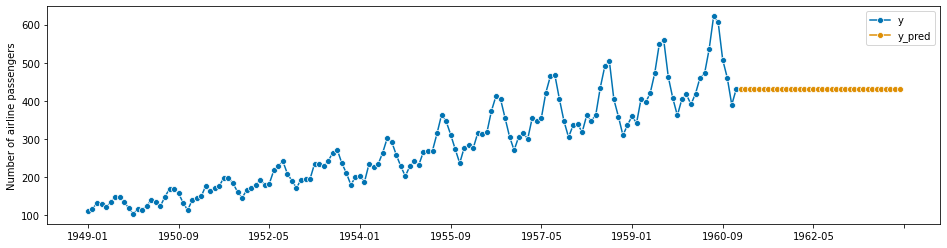

In [17]:
# plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

In Summary, we can implement the whole process in the following code cell

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

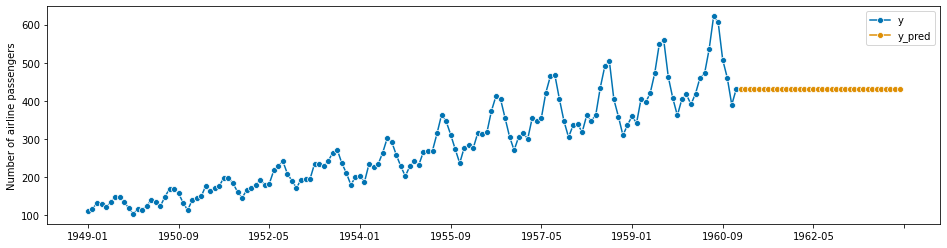

In [18]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=1)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

We can try increasing the period, which is the number of data points in the past that this focaster is repeating
set sp to 12


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

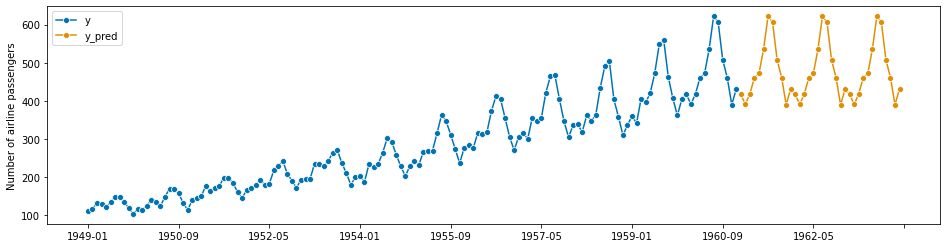

In [19]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["y", "y_pred"])

1.2.3 forecasters that can make use of exogeneous data
Many forecasters can make use of exogeneous time series, i.e., other time series that are not forecast, but are useful for forecasting y. Exogeneous time series are always passed as an X argument, in fit, predict, and other methods (see below). Exogeneous time series should always be passed as pandas.DataFrames. Most forecasters that can deal with exogeneous time series will assume that the time indices of X passed to fit are a super-set of the time indices in y passed to fit; and that the time indices of X passed to predict are a super-set of time indices in fh, although this is not a general interface restriction. Forecasters that do not make use of exogeneous time series still accept the argument (and do not use it internally).

The general workflow for passing exogeneous data is as follows:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

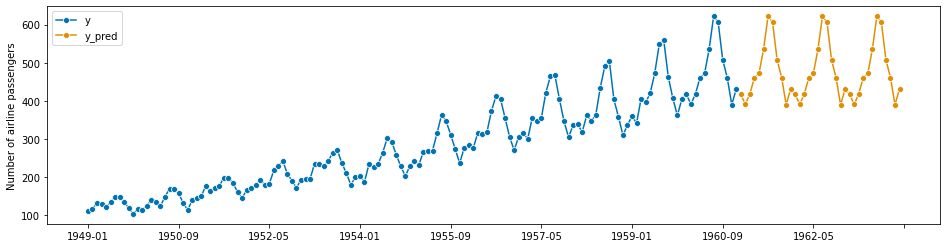

In [20]:
# step 1: data specification
y = load_airline()
# we create some dummy exogeneous data
X = pd.DataFrame(index=y.index)

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, X=X, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict(X=X)
plot_series(y, y_pred, labels=["y", "y_pred"])

NOTE: as in workflows 1.2.1 and 1.2.2, some forecasters that use exogeneous variables may also require the forecasting horizon only in predict. Such forecasters may also be called with steps 4 and 5 being

forecaster.fit(y, X=X)
y_pred = forecaster.predict(fh=fh, X=X)

1.2.4 prediction intervals
sktime provides a unified interface to return prediction interval when forecasting. This is possible directly in the predict function, by setting the return_pred_int argument to True. The predict method then returns a second argument, Not all forecasters are capable of returning prediction intervals, in which case an error will be raised.

Obtaining prediction intervals can be done as part of any workflow involving predict, by adding the argument return_pred_int - below, we illustrate this by modifying the basic workflow in Section 1.2:

In [21]:
from sktime.forecasting.theta import ThetaForecaster
# simple workflow
y = load_airline()
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y)

# setting return_pred_int argument to True; alpha determines percentiles
#  intervals are lower = alpha/2-percentile, upper = (1-alpha/2)-percentile
alpha = 0.05  # 2.5%/97.5% prediction intervals, aka 2 standard deviations
y_pred, y_pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

C:\Users\trana\.conda\envs\data_process\lib\site-packages\sktime\forecasting\base\_base.py:216: FutureWarning: return_pred_int in predict() will be deprecated;please use predict_interval() instead to generate prediction intervals.
  warn(


y_pred_ints is a pandas.DataFrame with columns lower and upper, and rows the indices for which forecasts were made (same as in y_pred). Entries are lower/upper (as column name) bound of the nominal alpha predictive interval for the index in the same row.

In [22]:
y_pred_ints

,lower,upper
1961-01,413.873756,468.688317
1961-02,396.979013,462.124924
1961-03,454.013506,528.063108
1961-04,435.998234,517.990290
1961-05,436.352091,525.582417
1961-06,498.874800,594.798752
1961-07,553.282848,655.462877
1961-08,548.675560,656.750127
1961-09,468.520990,582.184819
1961-10,398.349804,517.340642


Plot the predictive interval forecasts
NOTE: this should be turned into a one-liner, by moving this to utils.plotting - contributions are appreciated.

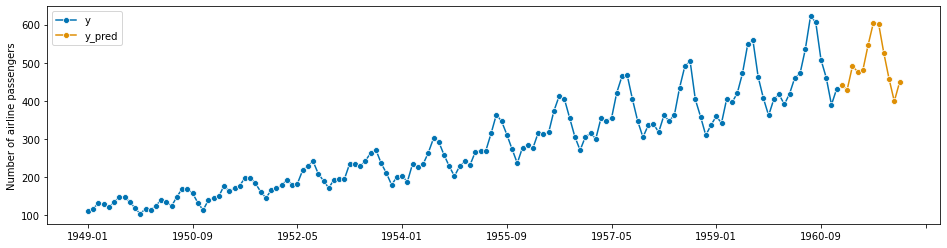

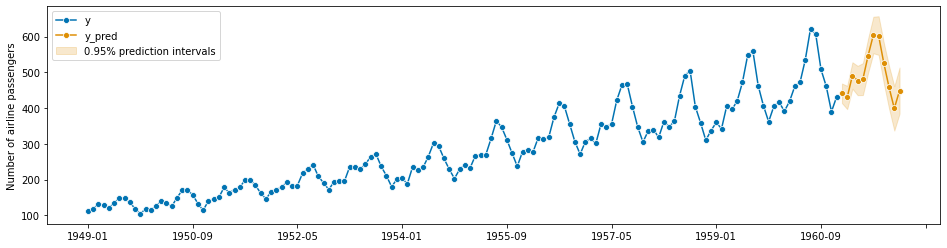

In [23]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

1.3 basic evaluation workflow - evaluating a batch of forecasts against ground truth observations
It is good practice to evaluate statistical performance of a forecaster before deploying it, and regularly re-evaluate performance if in continuous deployment. The evaluation workflow for the basic batch forecasting task, as solved by the workflow in Section 1.2, consists of comparing batch forecasts with actuals. This is sometimes called (batch-wise) backtesting.

The basic evaluation workflow is as follows:

1 - splitting a representatively chosen historical series into a temporal training and test set. The test set should be temporally in the future of the training set.
2 - obtaining batch forecasts, as in Section 1.2, by fitting a forecaster to the training set, and querying predictions for the test set
3 - specifying a quantitative performance metric to compare the actual test set against predictions
4 - computing the quantitative performance on the test set
5 - testing whether this performance is statistically better than a chosen baseline performance

NOTE: step 5 (testing) is currently not supported in sktime, but is on the development roadmap. For the time being, it is advised to use custom implementations of appropriate methods (e.g., Diebold-Mariano test; stationary confidence intervals).

NOTE: note that this evaluation set-up determines how well a given algorithm would have performed on past data. Results are only insofar representative as future performance can be assumed to mirror past performance. This can be argued under certain assumptions (e.g., stationarity), but will in general be false. Monitoring of forecasting performance is hence advised in case an algorithm is applied multiple times.

Example: In the example, we will use the same airline data as in Section 1.2. But, instead of predicting the next 3 years, we hold out the last 3 years of the airline data (y_test below), and see how the forecaster would have performed three years ago. In other words, when asked to forecast the most recent 3 years (y_pred below), we assign the last 3 years of data to be y_test; any data before this period is assigned to y_train and use this y_train to predict y_test.

To evaluate the quality of y_pred, a quantitative performance metric was used. There are many methods, but here mean_absolute_percentage_error is chosen. This metrics indicates how well the forecaster would perform in predicting y_test. Whether y_preds values are valid depends on statistical assumptions and data properties, but in general, future prediction should be taken with a grain of salt - past performance is not indicative of future performance.

step 1 - splitting a historical data set in to a temporal train and test batch

108 36


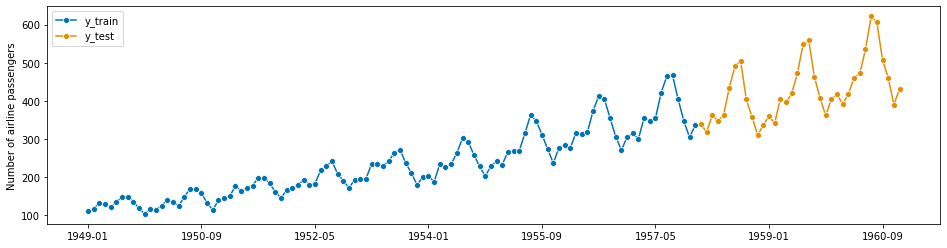

In [25]:
from sktime.forecasting.model_selection import temporal_train_test_split
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

step 2 - making forecasts for y_test from y_train
Repeating the workflow in Section 1.2, we use y_train to predict the values of y_test.

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

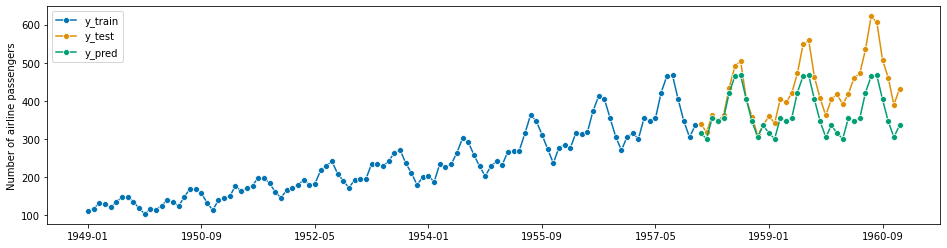

In [32]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

steps 3 and 4 - specifying a forecasting metric, evaluating on the test set
To evaluate y_pred, a forecasting metric is needed. In sktime, the functions calculating the metrics return a number when input with prediction and actual series. They are different from sklearn metrics in that they accept series with indices rather than np.arrays. Forecasting metrics can be invoked in two ways:

1 - Using the lean function interface, e.g., mean_absolute_percentage_error which is a python function [function_name](y_true : pd.Series, y_pred : pd.Series) -> float
2 - Using the composable class interface, e.g., MeanAbsolutePercentageError, which is a python class, callable with the same signature
Casual users may opt to use the function interface. The class interface supports advanced use cases, such as parameter modification, custom metric composition, tuning over metric parameters (not covered in this tutorial)

In [33]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.145427686270316

Mean Absolute Percentage Error calculates the average absolute percent error. Thus, the lower the percentage, the better.

In [34]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
# option 2: using the composable class interface
mape = MeanAbsolutePercentageError(symmetric=False)
# the class interface allows us to easily construct variants of the MAPE
#  e.g., the non-symmetric verion
# it also allows for inspection of metric properties
#  e.g., are higher values better (answer: no)?
mape.greater_is_better

False